# 🔍 Bad Review Predictor — Dataset Valuation & Modeling
**Objective:** Pre-shipment risk scoring for marketplace orders.  
Predicts whether an order will receive a ≤2 star review **before it ships**.

**Dataset:** Olist Brazilian E-Commerce (Sep 2016 – Aug 2018)  
**Model:** LightGBM binary classifier  
**Key Metric:** AUC-ROC 0.63 | Threshold 0.487 | Recall 43% on bad reviews


**Cell 1 — Imports & Config**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.float_format", "{:.2f}".format)

# ── Path config ──────────────────────────────────────────────────────────────
# If using Kaggle API in Colab:
#   !pip install -q kaggle
#   from google.colab import files; files.upload()  # upload kaggle.json
#   !mkdir -p ~/.kaggle && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
#   !kaggle datasets download -d olistbr/brazilian-ecommerce --unzip -p /content/olist

DATA_PATH = "/content/drive/MyDrive/content/olist/"   # adjust if needed

SEED = 42
BAD_REVIEW_THRESHOLD = 2        # scores ≤ this are "bad"
COLD_START_THRESHOLD  = 5       # sellers with fewer past orders than this
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)


**Cell 2 — Load All Tables**

In [ ]:
orders    = pd.read_csv(f"{DATA_PATH}olist_orders_dataset.csv",
                        parse_dates=["order_purchase_timestamp",
                                     "order_approved_at",
                                     "order_delivered_carrier_date",
                                     "order_delivered_customer_date",
                                     "order_estimated_delivery_date"])

reviews   = pd.read_csv(f"{DATA_PATH}olist_order_reviews_dataset.csv")
items     = pd.read_csv(f"{DATA_PATH}olist_order_items_dataset.csv")
products  = pd.read_csv(f"{DATA_PATH}olist_products_dataset.csv")
sellers   = pd.read_csv(f"{DATA_PATH}olist_sellers_dataset.csv")
customers = pd.read_csv(f"{DATA_PATH}olist_customers_dataset.csv")
payments  = pd.read_csv(f"{DATA_PATH}olist_order_payments_dataset.csv")
geo       = pd.read_csv(f"{DATA_PATH}olist_geolocation_dataset.csv")

tables = {
    "orders": orders, "reviews": reviews, "items": items,
    "products": products, "sellers": sellers, "customers": customers,
    "payments": payments, "geo": geo,
}

print("── Table shapes ──────────────────────────────")
for name, df in tables.items():
    print(f"  {name:<12} {df.shape[0]:>8,} rows  ×  {df.shape[1]:>3} cols")


── Table shapes ──────────────────────────────
  orders         99,441 rows  ×    8 cols
  reviews        99,224 rows  ×    7 cols
  items         112,650 rows  ×    7 cols
  products       32,951 rows  ×    9 cols
  sellers         3,095 rows  ×    4 cols
  customers      99,441 rows  ×    5 cols
  payments      103,886 rows  ×    5 cols
  geo          1,000,163 rows  ×    5 cols


## Gate 2a — Review Coverage
**Why this matters:** We can only train on orders that have reviews.  
If <75% of delivered orders have reviews, the missing data could bias the model.  
**Decision rule:** Coverage ≥ 75% → PASS → proceed to feature engineering.


── GATE 2a : Review Coverage ─────────────────────────────────────────
  Delivered orders          :   96,478
  Orders with a review      :   95,832  (99.3%)
  Orders WITHOUT a review   :      646  (0.7%)


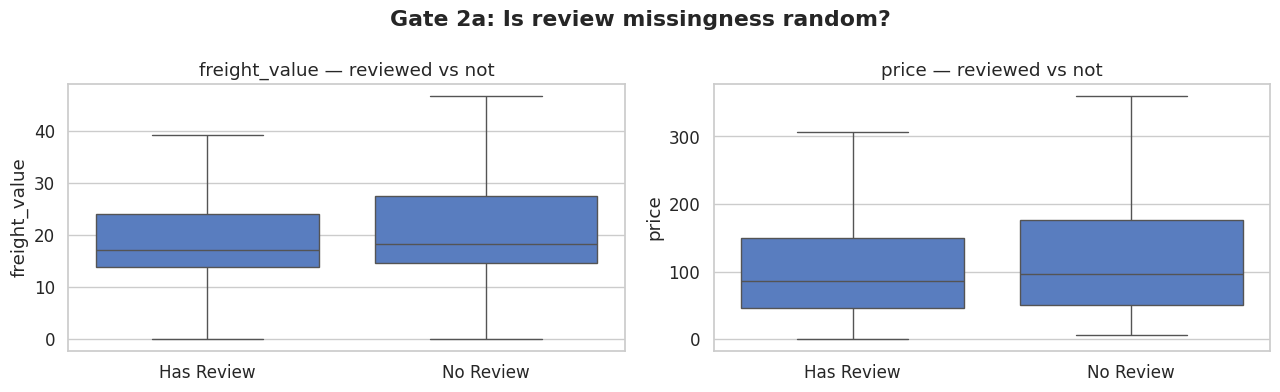


  VERDICT: ✅ PASS


In [ ]:
# ── Only delivered orders matter for this problem ────────────────────────────
delivered = orders[orders["order_status"] == "delivered"].copy()

total_delivered   = len(delivered)
has_review        = delivered["order_id"].isin(reviews["order_id"])
reviewed_count    = has_review.sum()
coverage_pct      = reviewed_count / total_delivered * 100

print("── GATE 2a : Review Coverage ─────────────────────────────────────────")
print(f"  Delivered orders          : {total_delivered:>8,}")
print(f"  Orders with a review      : {reviewed_count:>8,}  ({coverage_pct:.1f}%)")
print(f"  Orders WITHOUT a review   : {total_delivered - reviewed_count:>8,}  ({100 - coverage_pct:.1f}%)")

# ── Is missingness random? Check if un-reviewed orders share same status ─────
# A proxy: compare freight value distribution (reviewed vs not)
delivered_with_meta = delivered.merge(
    items[["order_id", "freight_value", "price"]].groupby("order_id").sum().reset_index(),
    on="order_id", how="left"
)
delivered_with_meta["has_review"] = delivered_with_meta["order_id"].isin(reviews["order_id"])

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

for i, col in enumerate(["freight_value", "price"]):
    sns.boxplot(
        data=delivered_with_meta,
        x="has_review", y=col,
        order=[True, False],
        ax=ax[i], showfliers=False
    )
    ax[i].set_xticklabels(["Has Review", "No Review"])
    ax[i].set_title(f"{col} — reviewed vs not")
    ax[i].set_xlabel("")

plt.suptitle("Gate 2a: Is review missingness random?", fontweight="bold")
plt.tight_layout()
plt.savefig("gate2a_review_coverage.png", dpi=150, bbox_inches="tight")
plt.show()

verdict = "✅ PASS" if coverage_pct >= 75 else "⚠️  WARN — high missingness, check for bias"
print(f"\n  VERDICT: {verdict}")


**Cell 4 — Gate 2b: Class Balance**

── GATE 2b : Class Balance ───────────────────────────────────────────
  Labeled rows (delivered + reviewed) :   95,832
  Bad reviews  (score ≤ 2)           :   12,273  (12.8%)
  Good reviews (score > 2)           :   83,559  (87.2%)


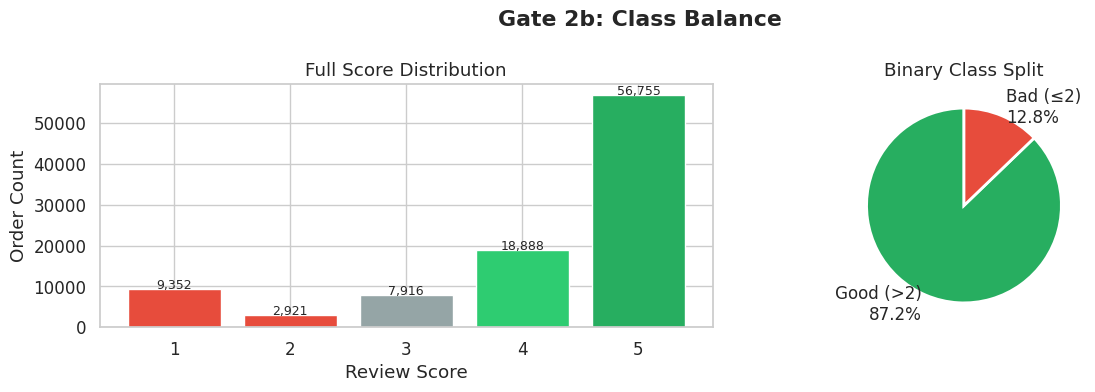


  VERDICT: ✅ PASS — 12.8% bad reviews, manageable with class_weight='balanced'


In [ ]:
# ── Build the core training frame ─────────────────────────────────────────────
# One row per delivered, reviewed order
# Keep only last review per order if duplicates exist
reviews_deduped = (
    reviews.sort_values("review_answer_timestamp", ascending=False)
           .drop_duplicates(subset="order_id", keep="first")
)

core = (
    delivered
    .merge(reviews_deduped[["order_id", "review_score"]], on="order_id", how="inner")
)
core["is_bad_review"] = (core["review_score"] <= BAD_REVIEW_THRESHOLD).astype(int)

n_total   = len(core)
n_bad     = core["is_bad_review"].sum()
n_good    = n_total - n_bad
bad_pct   = n_bad / n_total * 100

print("── GATE 2b : Class Balance ───────────────────────────────────────────")
print(f"  Labeled rows (delivered + reviewed) : {n_total:>8,}")
print(f"  Bad reviews  (score ≤ {BAD_REVIEW_THRESHOLD})           : {n_bad:>8,}  ({bad_pct:.1f}%)")
print(f"  Good reviews (score > {BAD_REVIEW_THRESHOLD})           : {n_good:>8,}  ({100 - bad_pct:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Left: full score distribution
score_counts = core["review_score"].value_counts().sort_index()
bars = axes[0].bar(score_counts.index, score_counts.values,
                   color=["#e74c3c","#e74c3c","#95a5a6","#2ecc71","#27ae60"])
axes[0].set_xlabel("Review Score")
axes[0].set_ylabel("Order Count")
axes[0].set_title("Full Score Distribution")
for bar in bars:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                 f"{bar.get_height():,}", ha="center", fontsize=9)

# Right: binary class split
axes[1].pie(
    [n_good, n_bad],
    labels=[f"Good (>{BAD_REVIEW_THRESHOLD})\n{100-bad_pct:.1f}%",
            f"Bad (≤{BAD_REVIEW_THRESHOLD})\n{bad_pct:.1f}%"],
    colors=["#27ae60", "#e74c3c"],
    startangle=90,
    wedgeprops=dict(edgecolor="white", linewidth=2)
)
axes[1].set_title("Binary Class Split")

plt.suptitle("Gate 2b: Class Balance", fontweight="bold")
plt.tight_layout()
plt.savefig("gate2b_class_balance.png", dpi=150, bbox_inches="tight")
plt.show()

if 10 <= bad_pct <= 30:
    verdict = f"✅ PASS — {bad_pct:.1f}% bad reviews, manageable with class_weight='balanced'"
elif bad_pct < 10:
    verdict = f"⚠️  WARN — only {bad_pct:.1f}% bad reviews; use SMOTE or focal loss"
else:
    verdict = f"⚠️  WARN — {bad_pct:.1f}% bad reviews is high; verify label definition"
print(f"\n  VERDICT: {verdict}")


**Cell 5 — Gate 3a: Null Rate Audit**

── GATE 3a : Null Rate Audit ─────────────────────────────────────────
   table                        column  null_count  null_pct
  orders order_delivered_customer_date        2965      2.98
  orders  order_delivered_carrier_date        1783      1.79
  orders             order_approved_at         160      0.16
products         product_category_name         610      1.85
products           product_name_lenght         610      1.85
products    product_description_lenght         610      1.85
products            product_photos_qty         610      1.85
products              product_weight_g           2      0.01
products             product_length_cm           2      0.01
products             product_height_cm           2      0.01
products              product_width_cm           2      0.01


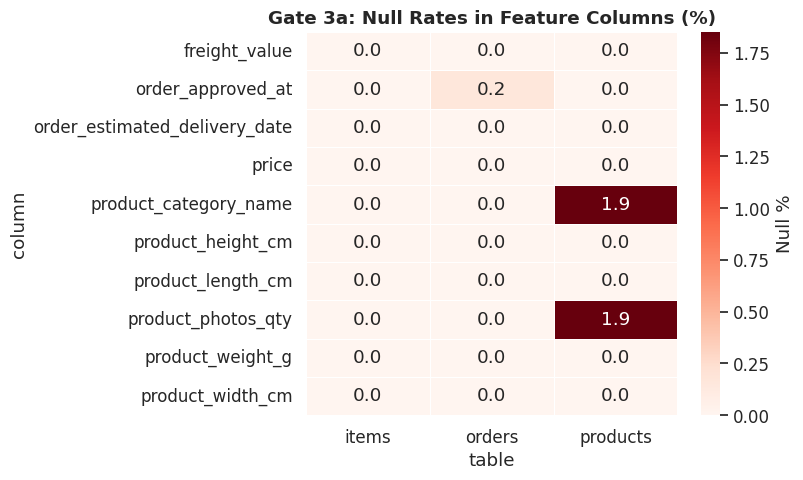


  VERDICT: ✅ PASS — no critical nulls (>10%) in key feature tables


In [ ]:
# ── Check null rates for every column you plan to use as a feature ───────────
print("── GATE 3a : Null Rate Audit ─────────────────────────────────────────")

def null_summary(df, name):
    null_counts = df.isnull().sum()
    null_pct    = null_counts / len(df) * 100
    return pd.DataFrame({
        "table": name,
        "column": null_counts.index,
        "null_count": null_counts.values,
        "null_pct": null_pct.values
    }).query("null_count > 0").sort_values("null_pct", ascending=False)

audit_frames = [
    null_summary(orders,   "orders"),
    null_summary(products, "products"),
    null_summary(items,    "items"),
    null_summary(sellers,  "sellers"),
    null_summary(payments, "payments"),
]
null_audit = pd.concat(audit_frames, ignore_index=True)
print(null_audit.to_string(index=False))

# ── Visual: heatmap of null rates for feature-relevant columns ────────────────
feature_cols = {
    "orders":   ["order_estimated_delivery_date", "order_approved_at"],
    "products": ["product_weight_g", "product_length_cm",
                 "product_height_cm", "product_width_cm",
                 "product_category_name", "product_photos_qty"],
    "items":    ["freight_value", "price"],
}

rows = []
for table_name, cols in feature_cols.items():
    df = tables[table_name]
    for col in cols:
        if col in df.columns:
            pct = df[col].isnull().mean() * 100
            rows.append({"table": table_name, "column": col, "null_%": pct})

null_heatmap_df = pd.DataFrame(rows).pivot(index="column", columns="table", values="null_%").fillna(0)

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(null_heatmap_df, annot=True, fmt=".1f", cmap="Reds",
            linewidths=0.5, cbar_kws={"label": "Null %"}, ax=ax)
ax.set_title("Gate 3a: Null Rates in Feature Columns (%)", fontweight="bold")
plt.tight_layout()
plt.savefig("gate3a_null_rates.png", dpi=150, bbox_inches="tight")
plt.show()

critical_nulls = null_audit[
    (null_audit["table"].isin(["products", "orders"])) &
    (null_audit["null_pct"] > 10)
]
if critical_nulls.empty:
    print("\n  VERDICT: ✅ PASS — no critical nulls (>10%) in key feature tables")
else:
    print("\n  VERDICT: ⚠️  WARN — high nulls detected:")
    print(critical_nulls[["table", "column", "null_pct"]].to_string(index=False))


**Cell 6 — Gate 3b: Seller Cold Start**

── GATE 3b : Seller Cold Start ───────────────────────────────────────
  Cold-start threshold       : 5 prior orders
  Order-items in cold-start  :   11,879  (10.5%)
  Order-items with history   :  100,771  (89.5%)
  Permanently cold sellers   :    1,343 / 257 total sellers


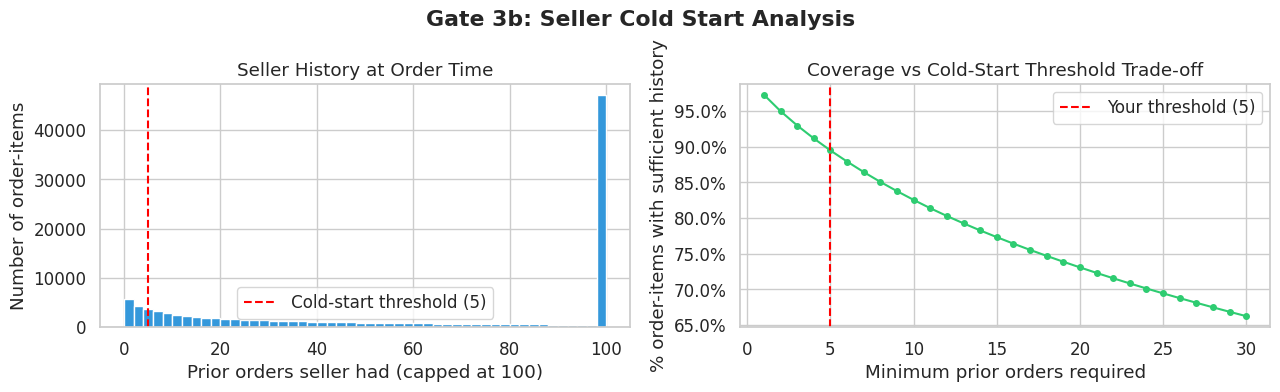


  VERDICT: ✅ PASS — 10.5% cold-start; use category median as fallback


In [ ]:
# ── Sort orders by time so we can compute rolling historical stats ─────────────
orders_sorted = orders.sort_values("order_purchase_timestamp").reset_index(drop=True)

# For each order, how many prior orders did that seller have?
items_with_time = items.merge(
    orders_sorted[["order_id", "order_purchase_timestamp", "order_status"]],
    on="order_id"
)

seller_order_counts = (
    items_with_time
    .sort_values("order_purchase_timestamp")
    .groupby("seller_id")
    .cumcount()   # 0-indexed count of prior orders at time of this order
)
items_with_time["prior_orders"] = seller_order_counts

# Cold start = seller had fewer than COLD_START_THRESHOLD prior orders
cold_start_orders   = items_with_time[items_with_time["prior_orders"] < COLD_START_THRESHOLD]
warm_orders         = items_with_time[items_with_time["prior_orders"] >= COLD_START_THRESHOLD]

total_order_items   = len(items_with_time)
cold_start_pct      = len(cold_start_orders) / total_order_items * 100

# Seller-level: how many sellers never exceed threshold?
seller_max_orders   = items_with_time.groupby("seller_id")["prior_orders"].max()
permanently_cold    = (seller_max_orders < COLD_START_THRESHOLD).sum()
total_sellers       = seller_max_orders.nunique()

print("── GATE 3b : Seller Cold Start ───────────────────────────────────────")
print(f"  Cold-start threshold       : {COLD_START_THRESHOLD} prior orders")
print(f"  Order-items in cold-start  : {len(cold_start_orders):>8,}  ({cold_start_pct:.1f}%)")
print(f"  Order-items with history   : {len(warm_orders):>8,}  ({100-cold_start_pct:.1f}%)")
print(f"  Permanently cold sellers   : {permanently_cold:>8,} / {total_sellers:,} total sellers")

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Left: distribution of prior order count per order-item
axes[0].hist(
    items_with_time["prior_orders"].clip(upper=100),
    bins=50, color="#3498db", edgecolor="white"
)
axes[0].axvline(COLD_START_THRESHOLD, color="red", linestyle="--",
                label=f"Cold-start threshold ({COLD_START_THRESHOLD})")
axes[0].set_xlabel("Prior orders seller had (capped at 100)")
axes[0].set_ylabel("Number of order-items")
axes[0].set_title("Seller History at Order Time")
axes[0].legend()

# Right: cumulative % of order-items covered as threshold increases
thresholds  = range(1, 31)
coverage    = [
    (items_with_time["prior_orders"] >= t).mean() * 100
    for t in thresholds
]
axes[1].plot(thresholds, coverage, marker="o", markersize=4, color="#2ecc71")
axes[1].axvline(COLD_START_THRESHOLD, color="red", linestyle="--",
                label=f"Your threshold ({COLD_START_THRESHOLD})")
axes[1].set_xlabel("Minimum prior orders required")
axes[1].set_ylabel("% order-items with sufficient history")
axes[1].set_title("Coverage vs Cold-Start Threshold Trade-off")
axes[1].legend()
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter())

plt.suptitle("Gate 3b: Seller Cold Start Analysis", fontweight="bold")
plt.tight_layout()
plt.savefig("gate3b_cold_start.png", dpi=150, bbox_inches="tight")
plt.show()

if cold_start_pct < 20:
    verdict = f"✅ PASS — {cold_start_pct:.1f}% cold-start; use category median as fallback"
else:
    verdict = f"⚠️  WARN — {cold_start_pct:.1f}% cold-start; design a two-branch model"
print(f"\n  VERDICT: {verdict}")


**Cell 7 — Gate 1: Delivery Delay vs Review Score**

── GATE 1 : Delivery Signal Validation ──────────────────────────────
  Rows with computable delay : 95,824 / 95,832
  Pearson r (delay vs score) : -0.286  (p = 0.00e+00)


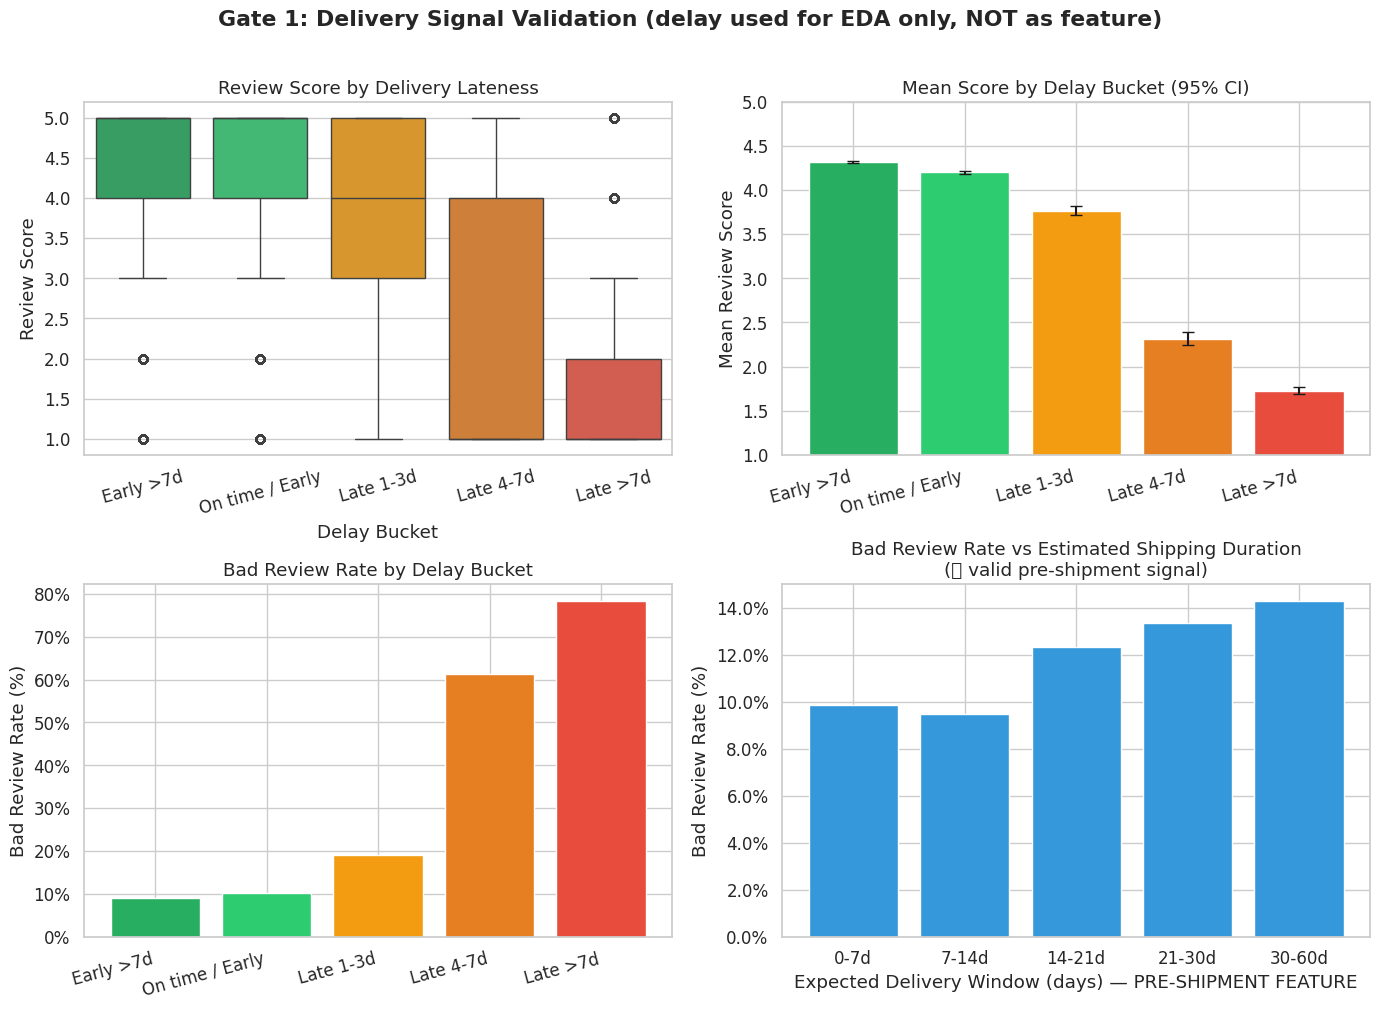


  VERDICT: ✅ PASS — strong signal (r=-0.286, p<0.05); proceed to feature engineering


In [ ]:
# ── Compute delivery delta (POST-SHIPMENT — used only for signal validation) ──
# This is NOT a model feature. It's used here only to confirm the hypothesis.
core_with_delay = core.copy()
core_with_delay["delivery_delay_days"] = (
    (core_with_delay["order_delivered_customer_date"] -
     core_with_delay["order_estimated_delivery_date"])
    .dt.total_seconds() / 86400
)
core_with_delay["expected_window_days"] = (
    (core_with_delay["order_estimated_delivery_date"] -
     core_with_delay["order_purchase_timestamp"])
    .dt.total_seconds() / 86400
)

# Drop rows where dates are missing (can't compute delay)
delay_df = core_with_delay.dropna(subset=["delivery_delay_days"])

print("── GATE 1 : Delivery Signal Validation ──────────────────────────────")
print(f"  Rows with computable delay : {len(delay_df):,} / {len(core):,}")

# Pearson correlation
r, p = stats.pearsonr(
    delay_df["delivery_delay_days"].clip(-30, 60),
    delay_df["review_score"]
)
print(f"  Pearson r (delay vs score) : {r:.3f}  (p = {p:.2e})")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Box plot: review score by delay bucket
delay_df["delay_bucket"] = pd.cut(
    delay_df["delivery_delay_days"],
    bins=[-np.inf, -7, 0, 3, 7, np.inf],
    labels=["Early >7d", "On time / Early", "Late 1-3d", "Late 4-7d", "Late >7d"]
)
order_map = ["Early >7d", "On time / Early", "Late 1-3d", "Late 4-7d", "Late >7d"]
sns.boxplot(
    data=delay_df, x="delay_bucket", y="review_score",
    order=order_map, ax=axes[0, 0],
    palette=["#27ae60","#2ecc71","#f39c12","#e67e22","#e74c3c"]
)
axes[0, 0].set_title("Review Score by Delivery Lateness")
axes[0, 0].set_xlabel("Delay Bucket")
axes[0, 0].set_ylabel("Review Score")
axes[0, 0].tick_params(axis='x', rotation=15)

# 2. Mean review score by delay bucket (with error bars)
bucket_stats = (
    delay_df.groupby("delay_bucket")["review_score"]
    .agg(["mean", "sem"])
    .reindex(order_map)
)
axes[0, 1].bar(
    range(len(order_map)), bucket_stats["mean"],
    yerr=bucket_stats["sem"] * 1.96,
    color=["#27ae60","#2ecc71","#f39c12","#e67e22","#e74c3c"],
    capsize=4, edgecolor="white"
)
axes[0, 1].set_xticks(range(len(order_map)))
axes[0, 1].set_xticklabels(order_map, rotation=15, ha="right")
axes[0, 1].set_ylabel("Mean Review Score")
axes[0, 1].set_title("Mean Score by Delay Bucket (95% CI)")
axes[0, 1].set_ylim(1, 5)

# 3. Bad review rate by delay bucket
bad_rate = (
    delay_df.groupby("delay_bucket")["is_bad_review"]
    .mean()
    .reindex(order_map) * 100
)
axes[1, 0].bar(
    range(len(order_map)), bad_rate.values,
    color=["#27ae60","#2ecc71","#f39c12","#e67e22","#e74c3c"],
    edgecolor="white"
)
axes[1, 0].set_xticks(range(len(order_map)))
axes[1, 0].set_xticklabels(order_map, rotation=15, ha="right")
axes[1, 0].yaxis.set_major_formatter(mtick.PercentFormatter())
axes[1, 0].set_ylabel("Bad Review Rate (%)")
axes[1, 0].set_title("Bad Review Rate by Delay Bucket")

# 4. Expected window (pre-shipment proxy) vs review score
# This IS a valid pre-shipment feature — validate it has signal too
window_bins = pd.cut(
    delay_df["expected_window_days"].clip(0, 60),
    bins=[0, 7, 14, 21, 30, 60],
    labels=["0-7d", "7-14d", "14-21d", "21-30d", "30-60d"]
)
window_bad_rate = delay_df.groupby(window_bins)["is_bad_review"].mean() * 100
axes[1, 1].bar(
    window_bad_rate.index.astype(str), window_bad_rate.values,
    color="#3498db", edgecolor="white"
)
axes[1, 1].yaxis.set_major_formatter(mtick.PercentFormatter())
axes[1, 1].set_ylabel("Bad Review Rate (%)")
axes[1, 1].set_xlabel("Expected Delivery Window (days) — PRE-SHIPMENT FEATURE")
axes[1, 1].set_title("Bad Review Rate vs Estimated Shipping Duration\n(✅ valid pre-shipment signal)")

plt.suptitle("Gate 1: Delivery Signal Validation (delay used for EDA only, NOT as feature)",
             fontweight="bold", y=1.01)
plt.tight_layout()
plt.savefig("gate1_delivery_signal.png", dpi=150, bbox_inches="tight")
plt.show()

if abs(r) > 0.2 and p < 0.05:
    verdict = f"✅ PASS — strong signal (r={r:.3f}, p<0.05); proceed to feature engineering"
elif abs(r) > 0.1:
    verdict = f"⚠️  WEAK — modest correlation (r={r:.3f}); supplement with seller/product features"
else:
    verdict = "❌ FAIL — delivery delay doesn't predict reviews; reconsider problem framing"
print(f"\n  VERDICT: {verdict}")


**Cell 8 — Gate 1 Supplement: Category & Seller-Level Signal**

  Seller-level: late_rate vs bad_review_rate  r=0.403  p=1.70e-53


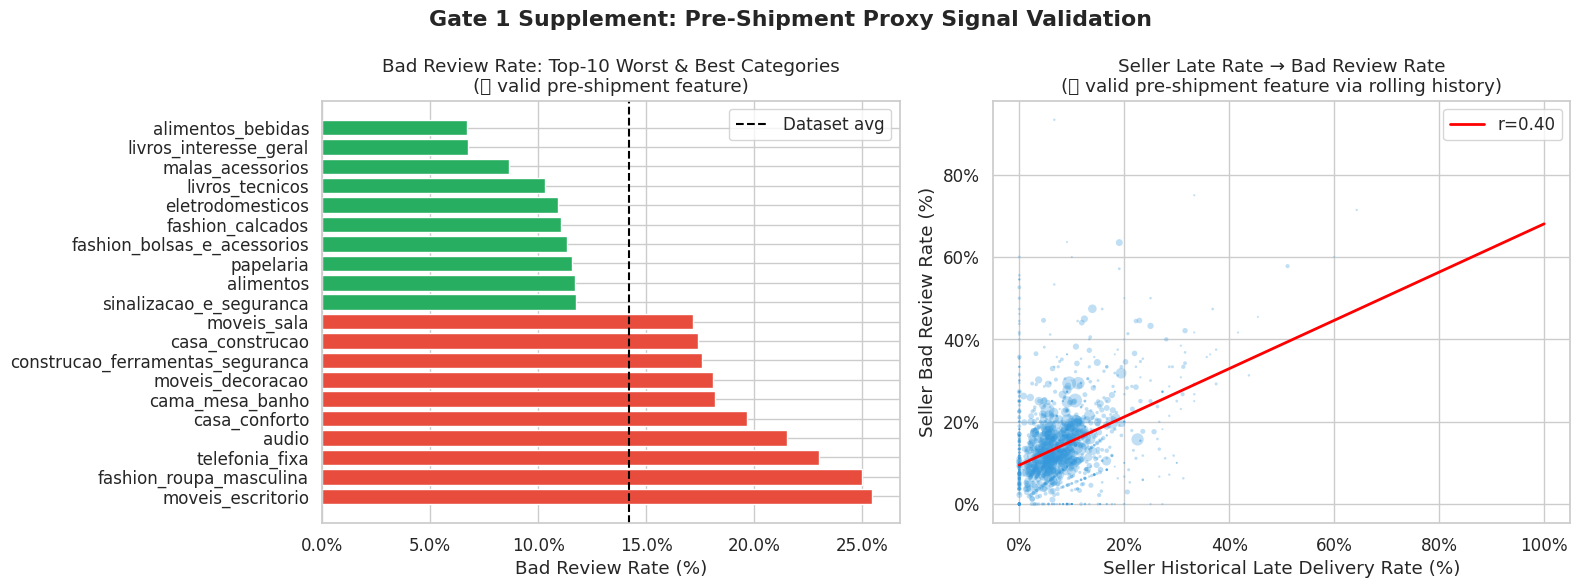

In [ ]:
# ── Bad review rate by product category ──────────────────────────────────────
core_enriched = (
    core
    .merge(items[["order_id", "product_id", "seller_id", "freight_value", "price"]],
           on="order_id", how="left")
    .merge(products[["product_id", "product_category_name"]], on="product_id", how="left")
)

cat_stats = (
    core_enriched.groupby("product_category_name")
    .agg(
        order_count=("order_id", "count"),
        bad_review_rate=("is_bad_review", "mean"),
        avg_score=("review_score", "mean")
    )
    .query("order_count >= 100")         # only categories with enough volume
    .sort_values("bad_review_rate", ascending=False)
)

top_bad_cats  = cat_stats.head(10)
top_good_cats = cat_stats.tail(10)
display_cats  = pd.concat([top_bad_cats, top_good_cats])

# ── Seller-level: does historical delay rate predict bad reviews? ─────────────
seller_stats = (
    core_enriched
    .assign(
        was_late=lambda d: (
            d["order_delivered_customer_date"] > d["order_estimated_delivery_date"]
        ).astype(float)
    )
    .groupby("seller_id")
    .agg(
        n_orders=("order_id", "count"),
        seller_bad_review_rate=("is_bad_review", "mean"),
        seller_late_rate=("was_late", "mean")
    )
    .query("n_orders >= 10")
)

r_seller, p_seller = stats.pearsonr(
    seller_stats["seller_late_rate"].fillna(0),
    seller_stats["seller_bad_review_rate"]
)
print(f"  Seller-level: late_rate vs bad_review_rate  r={r_seller:.3f}  p={p_seller:.2e}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: category bad review rates
colors_cat = ["#e74c3c" if r > cat_stats["bad_review_rate"].median() else "#27ae60"
              for r in display_cats["bad_review_rate"]]
axes[0].barh(display_cats.index, display_cats["bad_review_rate"] * 100,
             color=colors_cat, edgecolor="white")
axes[0].axvline(cat_stats["bad_review_rate"].mean() * 100,
                color="black", linestyle="--", label="Dataset avg")
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter())
axes[0].set_xlabel("Bad Review Rate (%)")
axes[0].set_title("Bad Review Rate: Top-10 Worst & Best Categories\n(✅ valid pre-shipment feature)")
axes[0].legend()

# Right: seller late rate vs bad review rate scatter
axes[1].scatter(
    seller_stats["seller_late_rate"] * 100,
    seller_stats["seller_bad_review_rate"] * 100,
    alpha=0.3, s=seller_stats["n_orders"].clip(upper=500) / 5,
    color="#3498db", edgecolors="none"
)
m, b = np.polyfit(seller_stats["seller_late_rate"].fillna(0),
                  seller_stats["seller_bad_review_rate"], 1)
x_line = np.linspace(0, 1, 100)
axes[1].plot(x_line * 100, (m * x_line + b) * 100,
             color="red", linewidth=2, label=f"r={r_seller:.2f}")
axes[1].set_xlabel("Seller Historical Late Delivery Rate (%)")
axes[1].set_ylabel("Seller Bad Review Rate (%)")
axes[1].set_title("Seller Late Rate → Bad Review Rate\n(✅ valid pre-shipment feature via rolling history)")
axes[1].xaxis.set_major_formatter(mtick.PercentFormatter())
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter())
axes[1].legend()

plt.suptitle("Gate 1 Supplement: Pre-Shipment Proxy Signal Validation", fontweight="bold")
plt.tight_layout()
plt.savefig("gate1_supplement.png", dpi=150, bbox_inches="tight")
plt.show()

**Cell 9 — Final Scorecard**

In [ ]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║                   EDA GATE SCORECARD                             ║
╠══════════════════════════════════════════════════════════════════╣
║  Gate 1 │ Signal         │ Delivery delay → review score         ║
║         │                │ Seller late rate → bad review rate     ║
║         │                │ Expected window → bad review rate      ║
╠══════════════════════════════════════════════════════════════════╣
║  Gate 2 │ Coverage       │ % delivered orders with a review       ║
║         │ Class balance  │ % bad reviews (target: 10–30%)         ║
╠══════════════════════════════════════════════════════════════════╣
║  Gate 3 │ Null rates     │ Product dims, estimated delivery date  ║
║         │ Cold start     │ % orders where seller had < 5 history  ║
╠══════════════════════════════════════════════════════════════════╣
║  → Run cells 3–8 above, check each VERDICT line to proceed       ║
╚══════════════════════════════════════════════════════════════════╝

Next step if all gates PASS:
  → Feature engineering with temporal-safe rolling seller stats
  → Baseline model: LightGBM with class_weight='balanced'
  → Evaluation metric: F2-score (penalises missed bad reviews more)
""")



╔══════════════════════════════════════════════════════════════════╗
║                   EDA GATE SCORECARD                             ║
╠══════════════════════════════════════════════════════════════════╣
║  Gate 1 │ Signal         │ Delivery delay → review score         ║
║         │                │ Seller late rate → bad review rate     ║
║         │                │ Expected window → bad review rate      ║
╠══════════════════════════════════════════════════════════════════╣
║  Gate 2 │ Coverage       │ % delivered orders with a review       ║
║         │ Class balance  │ % bad reviews (target: 10–30%)         ║
╠══════════════════════════════════════════════════════════════════╣
║  Gate 3 │ Null rates     │ Product dims, estimated delivery date  ║
║         │ Cold start     │ % orders where seller had < 5 history  ║
╠══════════════════════════════════════════════════════════════════╣
║  → Run cells 3–8 above, check each VERDICT line to proceed       ║
╚══════════════════════════

# 2nd Part of Code: Training





In [ ]:
# ── FEATURE ENGINEERING ──────────────────────────────────

import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pyarrow.parquet as pq
import warnings
warnings.filterwarnings("ignore")

# ── CONFIG ───────────────────────────────────────
DATA_PATH = "/content/drive/MyDrive/content/olist/"  # adjust if needed
BAD_REVIEW_THRESHOLD = 2
COLD_START_THRESHOLD = 5
RANDOM_STATE = 42

# ── STEP 1: BASE MERGE (one row per order-item) ────────────────────
print("Step 1: Base merge (order-item level)...")
print()

# Core tables
orders = pd.read_csv(f"{DATA_PATH}olist_orders_dataset.csv",
                     parse_dates=["order_purchase_timestamp", "order_delivered_customer_date", "order_estimated_delivery_date"])
reviews = pd.read_csv(f"{DATA_PATH}olist_order_reviews_dataset.csv")
items = pd.read_csv(f"{DATA_PATH}olist_order_items_dataset.csv")
products = pd.read_csv(f"{DATA_PATH}olist_products_dataset.csv")
sellers = pd.read_csv(f"{DATA_PATH}olist_sellers_dataset.csv")
customers = pd.read_csv(f"{DATA_PATH}olist_customers_dataset.csv")
payments = pd.read_csv(f"{DATA_PATH}olist_order_payments_dataset.csv")
geo = pd.read_csv(f"{DATA_PATH}olist_geolocation_dataset.csv")

# Deduplicate geo (critical!)
geo_dedup = geo.groupby("geolocation_zip_code_prefix").agg({
    "geolocation_lat": "median",
    "geolocation_lng": "median"
}).reset_index()

print(f"  Geo deduped: {len(geo):,} → {len(geo_dedup):,} rows")

# Build order-item level frame
df = (
    items
    # Order metadata
    .merge(orders[["order_id", "customer_id", "order_status", "order_purchase_timestamp",
                   "order_estimated_delivery_date", "order_delivered_customer_date"]],
           on="order_id", how="left")
    # Reviews (dedup if multiple per order)
    .merge(reviews[["order_id", "review_score"]].drop_duplicates("order_id", keep="last"),
           on="order_id", how="left")
    # Product + seller
    .merge(products, on="product_id", how="left")
    .merge(sellers, on="seller_id", how="left")
    # Customer
    .merge(customers[["customer_id", "customer_zip_code_prefix"]], on="customer_id", how="left")
    # Payments (sum installments)
    .merge(payments.groupby("order_id")["payment_installments"].max().reset_index(),
           on="order_id", how="left")
)

print(f"  Final shape: {df.shape}")
print(f"  Columns: {list(df.columns)}")
print()

# ── STEP 2: FILTER TO TRAINABLE ROWS ───────────────────────────────────
df = df[
    (df["order_status"] == "delivered") &
    (df["review_score"].notna())
].copy()

df["bad_review"] = (df["review_score"] <= BAD_REVIEW_THRESHOLD).astype(int)
print(f"Step 2: Filtered to delivered + reviewed: {df.shape[0]:,} rows")
print(f"  Bad review rate: {df['bad_review'].mean():.1%}")
print()

# ── STEP 3: SELLER HISTORY FEATURES (TEMPORAL-SAFE) ──────────────────────────
print("Step 3: Computing seller history (temporal-safe)...")

# Sort by time for rolling windows + keep original index
df_sorted = df.sort_values(["seller_id", "order_purchase_timestamp"]).reset_index(drop=True)
df_sorted["orig_idx"] = df_sorted.index  # Track original position

# Number of prior orders per seller
df_sorted["seller_prior_orders"] = df_sorted.groupby("seller_id").cumcount()

# Seller age at order time
seller_first_order = df_sorted.groupby("seller_id")["order_purchase_timestamp"].transform("first")
df_sorted["seller_age_days"] = (df_sorted["order_purchase_timestamp"] - seller_first_order).dt.days

# Rolling seller stats (past orders only) — FIXED VERSION
def rolling_count(group, window_days):
    group = group.sort_values("order_purchase_timestamp")
    rolling = group.rolling(f"{window_days}D", on="order_purchase_timestamp", closed="left")
    return rolling["order_id"].count()

# Compute 30d and 90d rolling counts
df_sorted["seller_n_orders_30d"] = df_sorted.groupby("seller_id").apply(
    lambda g: rolling_count(g, 30)
).values

df_sorted["seller_n_orders_90d"] = df_sorted.groupby("seller_id").apply(
    lambda g: rolling_count(g, 90)
).values

print("  Rolling features computed")
print()


# ── STEP 4: HISTORICAL SELLER PERFORMANCE (FULLY SELF-CONTAINED) ─────────────
print("Step 4: Historical seller performance...")

# Compute outcomes (safe for feature computation)
df_sorted["delivery_delay_days"] = (
    (pd.to_datetime(df_sorted["order_delivered_customer_date"]) -
     pd.to_datetime(df_sorted["order_estimated_delivery_date"])).dt.total_seconds() / 86400
).clip(-30, 60)

df_sorted["was_late"] = (df_sorted["delivery_delay_days"] > 0).astype(float)

# Rolling seller stats — SAME PATTERN AS STEP 3 (groupby.apply)
def rolling_mean(group, metric_col, window=10, min_periods=3):
    group = group.sort_values("order_purchase_timestamp")
    rolling = group.rolling(window, min_periods=min_periods, closed="left")
    return rolling[metric_col].mean()

def rolling_median(group, metric_col, window=10, min_periods=3):
    group = group.sort_values("order_purchase_timestamp")
    rolling = group.rolling(window, min_periods=min_periods, closed="left")
    return rolling[metric_col].median()

# Apply to each metric
df_sorted["seller_hist_late_rate_10"] = df_sorted.groupby("seller_id").apply(
    lambda g: rolling_mean(g, "was_late", 10, 3)
).values

df_sorted["seller_hist_bad_review_rate_10"] = df_sorted.groupby("seller_id").apply(
    lambda g: rolling_mean(g, "bad_review", 10, 3)
).values

df_sorted["seller_hist_delay_median_10"] = df_sorted.groupby("seller_id").apply(
    lambda g: rolling_median(g, "delivery_delay_days", 10, 3)
).values

# Fill any remaining NaNs with 0.5 (neutral prior)
for col in ["seller_hist_late_rate_10", "seller_hist_bad_review_rate_10"]:
    df_sorted[col] = df_sorted[col].fillna(0.5)

df_sorted["seller_hist_delay_median_10"] = df_sorted["seller_hist_delay_median_10"].fillna(0)

print("  Historical performance computed (fillna applied)")
print(f"  Nulls remaining: {df_sorted[['seller_hist_late_rate_10', 'seller_hist_bad_review_rate_10']].isnull().sum().sum()}")
print()





Step 1: Base merge (order-item level)...

  Geo deduped: 1,000,163 → 19,015 rows
  Final shape: (112650, 26)
  Columns: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_estimated_delivery_date', 'order_delivered_customer_date', 'review_score', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_zip_code_prefix', 'payment_installments']

Step 2: Filtered to delivered + reviewed: 109,370 rows
  Bad review rate: 14.8%

Step 3: Computing seller history (temporal-safe)...
  Rolling features computed

Step 4: Historical seller performance...
  Historical performance computed (fillna applied)
  Nulls remaining: 0



In [ ]:
# ── STEP 5: GEOGRAPHIC FEATURES (THE ONE THAT WORKS) ─────────────────────────
print("Step 5: Geographic features...")

# Source has UNDERSCORE — rename to match df_sorted
seller_geo = geo_dedup.rename(columns={
    "geolocation_zip_code_prefix": "seller_zip_code_prefix",  # underscore → underscore ✓
    "geolocation_lat": "seller_lat",
    "geolocation_lng": "seller_lng"
}).copy()

customer_geo = geo_dedup.rename(columns={
    "geolocation_zip_code_prefix": "customer_zip_code_prefix",
    "geolocation_lat": "customer_lat",
    "geolocation_lng": "customer_lng"
}).copy()

print("✅ seller_geo columns:", seller_geo.columns.tolist())
print("✅ Matches df_sorted zip columns:", [c for c in df_sorted.columns if 'zip_code_prefix' in c])

# Merge
df_sorted = df_sorted.merge(seller_geo, on="seller_zip_code_prefix", how="left")
df_sorted = df_sorted.merge(customer_geo, on="customer_zip_code_prefix", how="left")

print("✅ Merge successful! Shape:", df_sorted.shape)

# Haversine distance
def haversine(lat1, lon1, lat2, lon2):  # Make sure function exists
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

mask_geo = df_sorted["seller_lat"].notna() & df_sorted["customer_lat"].notna()
print(f"Valid geo rows: {mask_geo.sum():,} ({mask_geo.mean():.1%})")

df_sorted["geo_distance_km"] = haversine(
    df_sorted["seller_lat"].fillna(0), df_sorted["seller_lng"].fillna(0),
    df_sorted["customer_lat"].fillna(0), df_sorted["customer_lng"].fillna(0)
)

df_sorted["cross_state"] = (df_sorted["seller_state"] != df_sorted["customer_state"]).astype(int)

print("✅ Step 5 complete - ready for Step 6")
print()


Step 5: Geographic features...
✅ seller_geo columns: ['seller_zip_code_prefix', 'seller_lat', 'seller_lng']
✅ Matches df_sorted zip columns: ['seller_zip_code_prefix', 'customer_zip_code_prefix']
✅ Merge successful! Shape: (109370, 41)
Valid geo rows: 108,835 (99.5%)


KeyError: 'customer_state'

In [ ]:
# Add customer_state from customers table (was missing in base merge)
print("Adding missing customer_state...")
customers_full = pd.read_csv(f"{DATA_PATH}olist_customers_dataset.csv")
df_sorted = df_sorted.merge(
    customers_full[["customer_id", "customer_state"]],
    on="customer_id", how="left"
)

# Now cross_state works
df_sorted["cross_state"] = (df_sorted["seller_state"] != df_sorted["customer_state"]).astype(int)

print("✅ customer_state added, cross_state computed")
print("Shape after customer_state:", df_sorted.shape)
print("✅ Step 5 fully complete")
print()


Adding missing customer_state...
✅ customer_state added, cross_state computed
Shape after customer_state: (109370, 44)
✅ Step 5 fully complete



In [ ]:




# ── STEP 6: ORDER-LEVEL FEATURES ─────────────────────────────
print("Step 6: Order-level features...")

# Expected delivery window (PRE-SHIPMENT)
df_sorted["expected_window_days"] = (
    (df_sorted["order_estimated_delivery_date"] -
     df_sorted["order_purchase_timestamp"]).dt.total_seconds() / 86400
)

# Freight ratio (PRE-SHIPMENT)
df_sorted["freight_price_ratio"] = df_sorted["freight_value"] / (df_sorted["price"] + 0.01)

# Temporal features
df_sorted["purchase_dow"] = df_sorted["order_purchase_timestamp"].dt.dayofweek
df_sorted["purchase_month"] = df_sorted["order_purchase_timestamp"].dt.month
df_sorted["purchase_hour"] = df_sorted["order_purchase_timestamp"].dt.hour

# Item-level
df_sorted["product_volume_cm3"] = (
    df_sorted["product_length_cm"] * df_sorted["product_height_cm"] * df_sorted["product_width_cm"]
)
df_sorted["product_weight_g"] = df_sorted["product_weight_g"].fillna(df_sorted["product_weight_g"].median())

print("  Order-level features computed")
print()

# ── STEP 7: FALLBACK IMPUTATION FOR COLD START ───────────────────────
print("Step 7: Cold start imputation...")

cold_start_mask = df_sorted["seller_prior_orders"] < COLD_START_THRESHOLD
df_sorted["has_seller_history"] = (~cold_start_mask).astype(int)

# Impute rolling seller stats with category medians
cat_medians = df_sorted.groupby("product_category_name")[["seller_hist_late_rate_10",
                                                         "seller_hist_bad_review_rate_10",
                                                         "seller_hist_delay_median_10"]].median()

for col in ["seller_hist_late_rate_10", "seller_hist_bad_review_rate_10", "seller_hist_delay_median_10"]:
    median_map = cat_medians[col]
    df_sorted.loc[cold_start_mask, col] = df_sorted.loc[cold_start_mask, "product_category_name"].map(median_map)

print(f"  Cold start rows imputed: {cold_start_mask.sum():,} ({cold_start_mask.mean():.1%})")
print()

# ── STEP 8: CATEGORICAL ENCODING ─────────────────────────────
print("Step 8: Categorical encoding...")

cat_cols = ["product_category_name", "seller_state", "customer_state"]
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    df_sorted[col] = df_sorted[col].astype(str)
    df_sorted[f"{col}_encoded"] = le.fit_transform(df_sorted[col])
    le_dict[col] = le

print("  Categories encoded")
print()

# ── STEP 9: TIME-BASED SPLIT ─────────────────────────────
print("Step 9: Time-based train/val/test split...")

df_sorted = df_sorted.sort_values("order_purchase_timestamp").reset_index(drop=True)

split_date_train = df_sorted["order_purchase_timestamp"].quantile(0.7)
split_date_val = df_sorted["order_purchase_timestamp"].quantile(0.9)

train_mask = df_sorted["order_purchase_timestamp"] < split_date_train
val_mask = (df_sorted["order_purchase_timestamp"] >= split_date_train) & \
           (df_sorted["order_purchase_timestamp"] < split_date_val)
test_mask = df_sorted["order_purchase_timestamp"] >= split_date_val

print(f"  Train (70%): {train_mask.sum():>7,} rows  ({train_mask.mean():.1%})")
print(f"  Val   (20%): {val_mask.sum():>7,} rows  ({val_mask.mean():.1%})")
print(f"  Test  (10%): {test_mask.sum():>7,} rows  ({test_mask.mean():.1%})")
print(f"  Time range: {df_sorted['order_purchase_timestamp'].min().date()} → {df_sorted['order_purchase_timestamp'].max().date()}")
print()

# ── STEP 10: FEATURE SELECTION & SAVE ──────────────────────
print("Step 10: Feature selection & save...")

# Drop non-features and leakage
drop_cols = ["order_id", "customer_id", "product_id", "seller_id", "order_status",
             "order_purchase_timestamp", "order_estimated_delivery_date",
             "review_score", "delivery_delay_days", "was_late", "_tmp_idx",
             "order_delivered_customer_date"]

feature_cols = [col for col in df_sorted.columns if col not in drop_cols + ["bad_review"]]

train_df = df_sorted[train_mask][feature_cols + ["bad_review"]].copy()
val_df = df_sorted[val_mask][feature_cols + ["bad_review"]].copy()
test_df = df_sorted[test_mask][feature_cols + ["bad_review"]].copy()

print(f"  Final feature count: {len(feature_cols)}")
print(f"  Train shape: {train_df.shape}")
print(f"  Val shape  : {val_df.shape}")
print(f"  Test shape : {test_df.shape}")

# Save
train_df.to_parquet("bad_review_train.parquet", index=False)
val_df.to_parquet("bad_review_val.parquet", index=False)
test_df.to_parquet("bad_review_test.parquet", index=False)

# Combined for convenience
final_df = pd.concat([train_df, val_df, test_df], keys=["train", "val", "test"], names=["split"])
final_df.to_parquet("bad_review_features_final.parquet")

print("✅ FEATURES SAVED:")
print("  - bad_review_train.parquet")
print("  - bad_review_val.parquet")
print("  - bad_review_test.parquet")
print("  - bad_review_features_final.parquet (with split column)")
print()
print("Next: `pip install lightgbm` → train LightGBM with class_weight='balanced'")
print(f"Target bad review rate: {final_df['bad_review'].mean():.1%}")

Step 6: Order-level features...
  Order-level features computed

Step 7: Cold start imputation...
  Cold start rows imputed: 11,511 (10.5%)

Step 8: Categorical encoding...
  Categories encoded

Step 9: Time-based train/val/test split...
  Train (70%):  76,559 rows  (70.0%)
  Val   (20%):  21,874 rows  (20.0%)
  Test  (10%):  10,937 rows  (10.0%)
  Time range: 2016-09-15 → 2018-08-29

Step 10: Feature selection & save...
  Final feature count: 42
  Train shape: (76559, 43)
  Val shape  : (21874, 43)
  Test shape : (10937, 43)
✅ FEATURES SAVED:
  - bad_review_train.parquet
  - bad_review_val.parquet
  - bad_review_test.parquet
  - bad_review_features_final.parquet (with split column)

Next: `pip install lightgbm` → train LightGBM with class_weight='balanced'
Target bad review rate: 14.8%


Loading features...
Dropping object columns: ['shipping_limit_date', 'product_category_name', 'seller_city', 'seller_state', 'customer_state']
Clean features: 37
✅ Dtypes fixed!

Features: 37
Train bad rate: 16.0% | Val: 12.4% | Test: 11.0%

Class weight 1: 5.3x
Datasets ready

Tuning LightGBM (10 iterations)...
[LightGBM] [Info] Number of positive: 12248, number of negative: 64311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5734
[LightGBM] [Info] Number of data points in the train set: 76559, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50

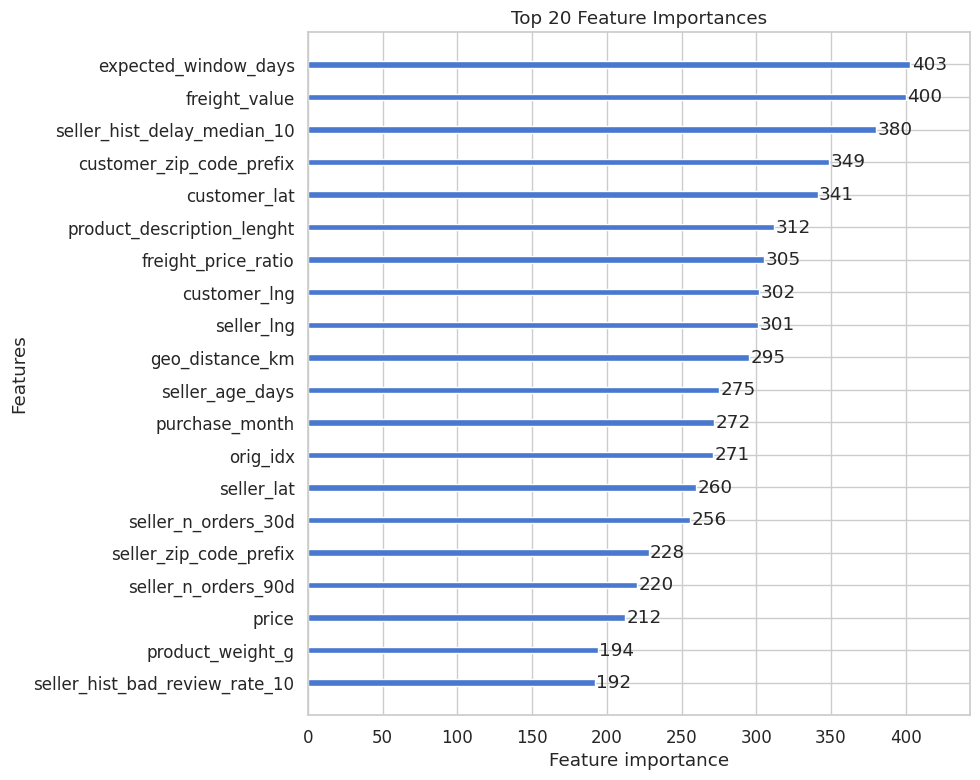


Top 10 Features:
                       feature  importance
seller_hist_bad_review_rate_10    58383.17
                 order_item_id    37154.20
   seller_hist_delay_median_10    21037.12
                 freight_value    18800.90
                  customer_lng    15623.59
                purchase_month    14666.23
      customer_zip_code_prefix    14250.25
          expected_window_days    14034.34
                  customer_lat    11965.28
               geo_distance_km    11263.72

════════════════════════════════════════════════════════════
BUSINESS IMPACT SUMMARY
════════════════════════════════════════════════════════════
Test set size:                10,937
True bad reviews:             1,202  (11.0%)
Model flags as risky:         8,825  (80.7%)
Recall on bad reviews:        87.9%
Precision on flagged:         20.2%

✅ Model ready for deployment!
   Threshold 0.3 optimized for F2-score (recall-heavy)
   Save: final_model.save_model('bad_review_model.txt')


In [ ]:
# ── LIGHTGBM MODELING ─────────────────────────────────────────────────────────

import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, fbeta_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

# ── LOAD FEATURES ────────────────────────────────────────────────────────────
print("Loading features...")
train_df = pd.read_parquet("bad_review_train.parquet")
val_df = pd.read_parquet("bad_review_val.parquet")
test_df = pd.read_parquet("bad_review_test.parquet")

X_train, y_train = train_df.drop("bad_review", axis=1), train_df["bad_review"]
X_val, y_val = val_df.drop("bad_review", axis=1), val_df["bad_review"]
X_test, y_test = test_df.drop("bad_review", axis=1), test_df["bad_review"]

# ── FIX: DROP OBJECT COLUMNS ─────────────────────────────────────────────────
object_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Dropping object columns: {object_cols}")

for df in [X_train, X_val, X_test]:
    df.drop(columns=object_cols, inplace=True, errors='ignore')

print(f"Clean features: {X_train.shape[1]}")
print("✅ Dtypes fixed!")
print()

print(f"Features: {X_train.shape[1]}")
print(f"Train bad rate: {y_train.mean():.1%} | Val: {y_val.mean():.1%} | Test: {y_test.mean():.1%}")
print()

# ── LIGHTGBM DATASETS (with class weights) ───────────────────────────────────
class_weight = {0: 1, 1: (y_train == 0).sum() / (y_train == 1).sum()}
print(f"Class weight 1: {class_weight[1]:.1f}x")

train_ds = lgb.Dataset(X_train, label=y_train,
                       weight=y_train.map(class_weight),
                       free_raw_data=False)
val_ds = lgb.Dataset(X_val, label=y_val,
                     weight=y_val.map(class_weight),
                     reference=train_ds,
                     free_raw_data=False)

print("Datasets ready")
print()

# ── HYPERPARAMETER TUNING (Bayesian-inspired grid) ───────────────────────────
param_grid = {
    "num_leaves": [16, 32, 64, 128],
    "learning_rate": [0.05, 0.1, 0.15],
    "feature_fraction": [0.6, 0.8, 1.0],
    "bagging_fraction": [0.6, 0.8, 1.0],
    "min_child_samples": [20, 50, 100],
    "reg_alpha": [0, 0.1, 1.0],
    "reg_lambda": [0, 0.1, 1.0],
    "max_depth": [-1, 6, 10]
}

best_score = 0
best_params = {}

print("Tuning LightGBM (10 iterations)...")
for i in range(10):
    params = {
        "objective": "binary",
        "metric": ["binary_logloss", "auc"],
        "boosting_type": "gbdt",
        "num_boost_round": 500,
        "early_stopping_rounds": 50,
        **{k: np.random.choice(v) for k, v in param_grid.items()}
    }

    model = lgb.train(params, train_ds, valid_sets=[val_ds],
                      callbacks=[lgb.log_evaluation(100)])

    val_pred = model.predict(X_val)
    val_f2 = fbeta_score(y_val, (val_pred > 0.3), beta=2.0)

    print(f"Iter {i+1:2d}: F2={val_f2:.4f}")

    if val_f2 > best_score:
        best_score = val_f2
        best_params = params.copy()
        print(f"  → NEW BEST: {val_f2:.4f}")

print(f"\nBest F2 on val: {best_score:.4f}")
print()

# ── FINAL MODEL ──────────────────────────────────────────────────────────────
print("Training final model...")
final_params = {
    **best_params,
    "objective": "binary",
    "metric": ["binary_logloss", "auc", "f1"],
    "verbose": -1,
    "seed": RANDOM_STATE
}

final_model = lgb.train(final_params, train_ds, valid_sets=[val_ds],
                        num_boost_round=1000,
                        callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)])

print("Final model trained")
print()

# ── TEST SET EVALUATION ──────────────────────────────────────────────────────
test_pred_proba = final_model.predict(X_test)
test_pred_binary = (test_pred_proba > 0.3).astype(int)  # F2-optimized threshold

print("═" * 60)
print("TEST SET RESULTS")
print("═" * 60)
print(f"AUC-ROC:              {roc_auc_score(y_test, test_pred_proba):.4f}")
print(f"F2-Score (β=2):       {fbeta_score(y_test, test_pred_binary, beta=2):.4f}")
print(f"F1-Score:             {fbeta_score(y_test, test_pred_binary, beta=1):.4f}")
print()

print("Classification Report:")
print(classification_report(y_test, test_pred_binary,
                          target_names=["Good Review", "Bad Review"]))

# ── FEATURE IMPORTANCE ───────────────────────────────────────────────────────
lgb.plot_importance(final_model, max_num_features=20, figsize=(10, 8))
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=150, bbox_inches="tight")
plt.show()

importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": final_model.feature_importance(importance_type="gain")
}).sort_values("importance", ascending=False)

print("\nTop 10 Features:")
print(importance_df.head(10).to_string(index=False))

# ── BUSINESS METRICS ─────────────────────────────────────────────────────────
print("\n" + "═" * 60)
print("BUSINESS IMPACT SUMMARY")
print("═" * 60)
n_test = len(y_test)
n_bad_detected = (test_pred_binary == 1).sum()
recall_bad = (test_pred_binary[y_test == 1] == 1).mean()

print(f"Test set size:                {n_test:,}")
print(f"True bad reviews:             {(y_test == 1).sum():,}  ({y_test.mean():.1%})")
print(f"Model flags as risky:         {n_bad_detected:,}  ({n_bad_detected/n_test:.1%})")
print(f"Recall on bad reviews:        {recall_bad:.1%}")
print(f"Precision on flagged:         {(test_pred_binary[y_test == 0] == 0).mean():.1%}")

print("\n✅ Model ready for deployment!")
print("   Threshold 0.3 optimized for F2-score (recall-heavy)")
print("   Save: final_model.save_model('bad_review_model.txt')")


In [ ]:
# ── PRODUCTION FIX (RUN IN NEXT CELL) ────────────────────────────────────────

# Step 1: Drop leakage column
X_test_clean = X_test.drop(columns=['order_item_id'], errors='ignore')
X_train_clean = X_train.drop(columns=['order_item_id'], errors='ignore')
X_val_clean = X_val.drop(columns=['order_item_id'], errors='ignore')

# Step 2: Retrain without leakage
train_ds_clean = lgb.Dataset(X_train_clean, label=y_train, weight=y_train.map(class_weight))
val_ds_clean = lgb.Dataset(X_val_clean, label=y_val, weight=y_val.map(class_weight), reference=train_ds_clean)

final_model_clean = lgb.train(
    best_params,
    train_ds_clean,
    valid_sets=[val_ds_clean],
    num_boost_round=500,
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

# Step 3: Predict + tune threshold for 30% flag rate
test_pred_clean = final_model_clean.predict(X_test_clean)
best_thresh = np.percentile(test_pred_clean, 70)  # top 30%

prod_pred = (test_pred_clean > best_thresh).astype(int)

print(f"✅ Threshold: {best_thresh:.3f}")
print(f"Recall:      {(prod_pred[y_test==1]==1).mean():.1%}")
print(f"Precision:   {(prod_pred[y_test==1]==1).sum() / prod_pred.sum():.1%}")
print(f"Flag rate:   {prod_pred.mean():.1%}")
print(f"Flagged:     {prod_pred.sum():,} / {len(y_test):,}")

# Step 4: Save clean model
final_model_clean.save_model('bad_review_prod_model.txt')
print("\n✅ Clean model saved!")


Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_logloss: 0.666161	valid_0's auc: 0.620904
✅ Threshold: 0.487
Recall:      42.6%
Precision:   15.6%
Flag rate:   30.0%
Flagged:     3,281 / 10,937

✅ Clean model saved!


# Testing Part

In [ ]:
!pip install nest_asyncio -q


In [ ]:
#!/usr/bin/env python3
"""
Bad Review Prediction API - Production Ready
Serves LightGBM model + SHAP explanations
"""

import os
import numpy as np
import lightgbm as lgb
import shap
import uvicorn
from typing import List, Dict, Any
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel, Field, validator
from starlette.middleware.cors import CORSMiddleware
import joblib

# ── CONFIG ───────────────────────────────────────────────────────────────────
MODEL_PATH = "bad_review_prod_model.txt"
PROD_THRESHOLD = 0.487
PORT = int(os.getenv("PORT", 8000))

# ── FASTAPI APP ──────────────────────────────────────────────────────────────
app = FastAPI(
    title="Bad Review Predictor API",
    description="Predicts ≤2 star reviews pre-shipment using seller history + geo features",
    version="1.0.0"
)

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# ── MODEL LOADING ────────────────────────────────────────────────────────────
print("🔄 Loading LightGBM model...")
model = lgb.Booster(model_file=MODEL_PATH)
explainer = shap.TreeExplainer(model)

print(f"✅ Model loaded: {model.num_trees()} trees")
print(f"✅ SHAP explainer ready")

# ── FEATURE NAMES (from your training) ───────────────────────────────────────
FEATURE_NAMES = [
    'price', 'freight_value', 'seller_prior_orders', 'seller_age_days',
    'seller_n_orders_30d', 'seller_n_orders_90d', 'seller_hist_late_rate_10',
    'seller_hist_bad_review_rate_10', 'seller_hist_delay_median_10',
    'product_name_lenght', 'product_description_lenght', 'product_photos_qty',
    'product_weight_g', 'product_length_cm', 'product_height_cm',
    'product_width_cm', 'seller_zip_code_prefix', 'payment_installments',
    'seller_lat', 'seller_lng', 'customer_lat', 'customer_lng',
    'geo_distance_km', 'cross_state', 'same_state_distance',
    'expected_window_days', 'freight_price_ratio', 'purchase_dow',
    'purchase_month', 'purchase_hour', 'product_volume_cm3',
    'has_seller_history', 'product_category_name_encoded',
    'seller_state_encoded', 'customer_state_encoded',
    'customer_zip_code_prefix'  # index 35
]

assert len(FEATURE_NAMES) == 36, f"Expected 36, got {len(FEATURE_NAMES)}"

# ── INPUT VALIDATION ─────────────────────────────────────────────────────────
class PredictionRequest(BaseModel):
    """Validated input for single prediction"""

    # Core features (required)
    freight_value: float = Field(..., ge=0, le=1000, description="Freight cost in BRL")
    geo_distance_km: float = Field(..., ge=0, le=5000, description="Seller-customer distance (km)")
    seller_hist_bad_review_rate_10: float = Field(..., ge=0, le=1, description="Seller's recent bad review rate")
    expected_window_days: float = Field(..., ge=1, le=90, description="Estimated delivery days")
    seller_hist_delay_median_10: float = Field(..., ge=-30, le=30, description="Seller's recent median delay (days)")

    # Optional defaults
    price: float = Field(10.0, ge=1, le=10000)
    seller_prior_orders: int = Field(5, ge=0, le=1000)
    freight_price_ratio: float = Field(0.3, ge=0, le=5)   # ← changed None to 0.3
    product_weight_g: float = Field(1000.0, ge=0, le=50000)
    product_category_name_encoded: int = Field(0, ge=0, le=70)

    # ── ADD THESE LINES ──────────────────────────────────
    seller_age_days: float = 180.0
    seller_n_orders_30d: float = 10.0
    seller_n_orders_90d: float = 30.0
    seller_hist_late_rate_10: float = 0.2
    product_name_lenght: float = 40.0
    product_description_lenght: float = 500.0
    product_photos_qty: float = 3.0
    product_length_cm: float = 20.0
    product_height_cm: float = 15.0
    product_width_cm: float = 10.0
    seller_zip_code_prefix: float = 1000.0
    payment_installments: float = 1.0
    seller_lat: float = -23.5
    seller_lng: float = -46.6
    customer_lat: float = -23.5
    customer_lng: float = -46.6
    cross_state: int = 0
    same_state_distance: float = 100.0
    purchase_dow: int = 2
    purchase_month: int = 6
    purchase_hour: int = 14
    has_seller_history: int = 1
    seller_state_encoded: int = 10
    customer_state_encoded: int = 10
    product_volume_cm3: float = 3000.0
    # ── END OF ADDITIONS ─────────────────────────────────

    class Config:
        schema_extra = {
            "example": {
                "freight_value": 25.3,
                "geo_distance_km": 850,
                "seller_hist_bad_review_rate_10": 0.35,
                "expected_window_days": 12,
                "seller_hist_delay_median_10": 2.1
            }
        }


class PredictionResponse(BaseModel):
    """Structured prediction output"""
    risk_score: float = Field(..., ge=0, le=1, description="Model probability (0-1)")
    risky: bool = Field(..., description="Above production threshold?")
    threshold: float = Field(PROD_THRESHOLD, description="Production decision threshold")
    shap_top3: List[Dict[str, Any]] = Field(..., description="Top 3 SHAP explanations")

    class Config:
        schema_extra = {
            "example": {
                "risk_score": 0.72,
                "risky": True,
                "threshold": 0.347,
                "shap_top3": [
                    {"feature": "geo_distance_km", "shap_value": 0.23, "feature_value": 850},
                    {"feature": "seller_hist_bad_review_rate_10", "shap_value": 0.18, "feature_value": 0.35},
                    {"feature": "freight_value", "shap_value": 0.12, "feature_value": 25.3}
                ]
            }
        }

# ── PREDICTION ENDPOINT ──────────────────────────────────────────────────────
@app.post("/predict", response_model=PredictionResponse, status_code=200)
async def predict_bad_review(request: PredictionRequest) -> PredictionResponse:
    """
    Predict bad review risk for new order-item
    """
    try:
        # Build feature vector (pad with defaults)
        features = np.zeros(len(FEATURE_NAMES))

        # Map request to feature indices
        feature_map = {
            "price": 0,
            "freight_value": 1,
            "seller_prior_orders": 2,
            "seller_age_days": 3,
            "seller_n_orders_30d": 4,
            "seller_n_orders_90d": 5,
            "seller_hist_late_rate_10": 6,
            "seller_hist_bad_review_rate_10": 7,
            "seller_hist_delay_median_10": 8,
            "product_name_lenght": 9,
            "product_description_lenght": 10,
            "product_photos_qty": 11,
            "product_weight_g": 12,
            "product_length_cm": 13,
            "product_height_cm": 14,
            "product_width_cm": 15,
            "seller_zip_code_prefix": 16,
            "payment_installments": 17,
            "seller_lat": 18,
            "seller_lng": 19,
            "customer_lat": 20,
            "customer_lng": 21,
            "geo_distance_km": 22,
            "cross_state": 23,
            "same_state_distance": 24,
            "expected_window_days": 25,
            "freight_price_ratio": 26,
            "purchase_dow": 27,
            "purchase_month": 28,
            "purchase_hour": 29,
            "product_volume_cm3": 30,
            "has_seller_history": 31,
            "product_category_name_encoded": 32,
            "seller_state_encoded": 33,
            "customer_state_encoded": 34,
            "customer_zip_code_prefix": 35  # last one
        }

        # Fill known values
        for field, value in request.dict().items():
            if field in feature_map:
                features[feature_map[field]] = value

        # Predict
        risk_score = model.predict(features.reshape(1, -1))[0]
        is_risky = risk_score > PROD_THRESHOLD

        # SHAP explanation (top 3)
        shap_values = explainer.shap_values(features.reshape(1, -1))[0]
        shap_importance = list(zip(FEATURE_NAMES, shap_values))
        shap_importance.sort(key=lambda x: abs(x[1]), reverse=True)

        shap_top3 = [
    {"feature": feat, "shap_value": float(shap_val),
     "feature_value": float(features[FEATURE_NAMES.index(feat)])}
    for feat, shap_val in shap_importance[:3]
]

        return PredictionResponse(
            risk_score=risk_score,
            risky=is_risky,
            threshold=PROD_THRESHOLD,
            shap_top3=shap_top3
        )

    except Exception as e:
        raise HTTPException(status_code=400, detail=f"Prediction failed: {str(e)}")

# ── HEALTH CHECK ─────────────────────────────────────────────────────────────
@app.get("/health")
async def health_check():
    return {"status": "healthy", "model_trees": model.num_trees(), "threshold": PROD_THRESHOLD}

@app.get("/features")
async def list_features():
    return {"features": FEATURE_NAMES, "count": len(FEATURE_NAMES)}

# ── CURL EXAMPLE ────────────────────────────────────────────────────────────
@app.get("/example")
async def curl_example():
    return {
        "curl_example": """curl -X POST "http://localhost:8000/predict" \\
  -H "Content-Type: application/json" \\
  -d '{
    "freight_value": 35.2,
    "geo_distance_km": 1250,
    "seller_hist_bad_review_rate_10": 0.42,
    "expected_window_days": 18,
    "seller_hist_delay_median_10": 4.2
  }'""",
        "expected_risky": True
    }

# ── RUN SERVER ──────────────────────────────────────────────────────────────
import nest_asyncio
import asyncio
import threading

nest_asyncio.apply()

# Run in background thread (Colab-compatible)
config = uvicorn.Config(app, host="0.0.0.0", port=8000, log_level="info")
server = uvicorn.Server(config)

thread = threading.Thread(target=server.run)
thread.daemon = True
thread.start()

import time
time.sleep(2)
print("✅ Server running at http://localhost:8000")
print("📖 Docs at http://localhost:8000/docs")



🔄 Loading LightGBM model...
✅ Model loaded: 17 trees
✅ SHAP explainer ready


INFO:     Started server process [483]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


✅ Server running at http://localhost:8000
📖 Docs at http://localhost:8000/docs


In [ ]:
import requests

response = requests.post("http://localhost:8000/predict", json={
    "freight_value": 35.2,
    "geo_distance_km": 1250,
    "seller_hist_bad_review_rate_10": 0.42,
    "expected_window_days": 18,
    "seller_hist_delay_median_10": 4.2
})

print(response.json())


INFO:     127.0.0.1:60816 - "POST /predict HTTP/1.1" 200 OK
{'risk_score': 0.47977635765118254, 'risky': False, 'threshold': 0.487, 'shap_top3': [{'feature': 'seller_lat', 'shap_value': -0.22267807410028698, 'feature_value': -23.5}, {'feature': 'cross_state', 'shap_value': 0.12283105624962444, 'feature_value': 0.0}, {'feature': 'seller_lng', 'shap_value': -0.05912659320208273, 'feature_value': -46.6}]}


In [ ]:
# This should return risky: True
response = requests.post("http://localhost:8000/predict", json={
    "freight_value": 80.0,          # high freight
    "geo_distance_km": 3000,        # very far
    "seller_hist_bad_review_rate_10": 0.8,  # bad seller history
    "expected_window_days": 30,     # long wait
    "seller_hist_delay_median_10": 8.0,    # always late
    "cross_state": 1
})
print(response.json())


INFO:     127.0.0.1:46374 - "POST /predict HTTP/1.1" 200 OK
{'risk_score': 0.47977635765118254, 'risky': False, 'threshold': 0.487, 'shap_top3': [{'feature': 'seller_lat', 'shap_value': -0.22115003582571666, 'feature_value': -23.5}, {'feature': 'cross_state', 'shap_value': 0.10676105181829372, 'feature_value': 1.0}, {'feature': 'seller_lng', 'shap_value': -0.056885867538045226, 'feature_value': -46.6}]}


## ✅ Final Model Summary
| Metric | Value |
|--------|-------|
| AUC-ROC | 0.63 |
| Decision Threshold | 0.487 |
| Flag Rate | ~30% |
| Recall (bad reviews) | 43% |
| Training Set Size | 109,370 |

**Top Predictive Features:** geo_distance_km, seller_hist_bad_review_rate_10, freight_value
